In [1]:
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import copy
import scipy
from scipy.io import loadmat
from scipy.io import savemat
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
from utils import *
from envs.cart_pole_env import CartPoleEnv
from envs.hopper_env import HopperModEnv
from envs.cheetah_env import CheetahModEnv

# Part 1 [30 pt] - Linear Environment
We start with the linear environment, similar to the one on the previous homework, and we consider optimizing for a sequence of actions, comparing shooting and collocation.

First, we define the environment:

In [2]:
class LinearEnv(object):
    def __init__(self, horizon=20, multiplier=1.):
        self.A = multiplier * 0.1 * np.array([[0.0481, -0.5049, 0.0299, 2.6544, 1.0608],
                                 [2.3846, -0.2312, -0.1260, -0.7945, 0.5279],
                                 [1.4019, -0.6394, -0.1401, 0.5484, 0.1624],
                                 [-0.0254, 0.4595, -0.0862, 2.1750, 1.1012],
                                 [0.5172, 0.5060, 1.6579, -0.9407, -1.4441]])
        self.B = np.array([[-0.7789, -1.2076],
                           [0.4299, -1.6041],
                           [0.2006, -1.7395],
                           [0.8302, 0.2295],
                           [-1.8465, 1.2780]])
        self.H = 20

        self.dx = self.A.shape[1]
        self.du = self.B.shape[1]
        self.Q = np.eye(self.dx)
        self.R = np.eye(self.du)
        self._init_state =  np.array([-1.9613, -1.3127, 0.0698, 0.0935, 1.2494])
        self.reset()

    def step(self, act):
        cost = self._state.T @ self.Q @ self._state + act.T @ self.R @ act
        state = self.A @ self._state + self.B @ act
        self._state = state.copy()
        return state, cost, False, {}

    def set_state(self, state):
        self._state = state.copy()

    def reset(self):
        self._state = self._init_state.copy()
        return self._init_state.copy()

In [3]:
env = LinearEnv()

Now, we implement the non-linear optimzation algorithms. A correct implementation should 
give an optimal cost of 7.461 for both methods, and a collocation error of 0.

## [15 pt] Shooting

In the shooting method, we look for the sequences of actions that minimizes the total cost by directly substuting the constraints in the objective:

$$ \min_{u_0, \dots, u_H} c(x_0, u_0) + c(f(x_0, u_0), u_1) + c(f(f(x_0, u_0), u_1) \cdots $$


In order to perform the optimization, we need to define the objective function to optimize.
Fill in the code in ```eval_shooting``` which should return the cost of the trajectory
with the specified sequences of actions.

In [4]:
def eval_shooting(actions, env):
    """
    Find the cumulative cost of the sequences of actions, which has shape [horizon, action dimension].
    Use the function step of the environment: env.step(action). It returns: next_state, cost, done,
    env_infos.
    """
    state = env.reset()
    actions = actions.reshape(env.H, env.du)
    horizon = env.H
    
    total_cost = 0

    
    """YOUR CODE HERE"""
    for i in range(horizon):
        action = actions[i]
        state, cost, done, _ = env.step(action)
        total_cost += cost

    """YOUR CODE ENDS HERE"""
    return total_cost

Once we have defined the objective function, we can use an off-the-shelf optimizer 
to find the optimal actions. In these case, we use 
[BFGS](https://docs.scipy.org/doc/scipy-0.16.0/reference/optimize.minimize-bfgs.html#optimize-minimize-bfgs),
which is a quasi-Newton method.

In [5]:
def minimize_shooting(env, init_actions=None):
    if init_actions is None:
        init_actions = np.random.uniform(low=-.1, high=.1, size=(env.H * env.du,))
    """YOUR CODE HERE"""
    res = minimize(fun= eval_shooting,
               x0= init_actions,
               args = (env),
               method='BFGS',
               options={'xtol': 1e-6, 'disp': False, 'verbose': 2}
              )

    act_shooting = res.x
    print(res.message)
    print("The optimal cost is %.3f" % res.fun)
    policy_shooting = ActPolicy(env=env, 
                                actions=act_shooting
                               )
    return policy_shooting
"""YOUR CODE ENDS HERE"""

policy_shooting = minimize_shooting(env)

Optimization terminated successfully.
The optimal cost is 7.461


## [15 pt] Collocation
Now we will do the same, but for the collocation method.  In addition to the objective function, we also have to formulate the equality constraints that capture the dynamics.

$$ \min_{u_0, x_1, u_1, \dots, x_H, u_H} c(x_0, u_0) + c(x_1, u_1) + \cdots + c(x_H, u_H)$$
$$\text{s.t.:} \quad x_{t+1} = f(x_t, u_t) \quad \forall t$$

Fill in the code in ``eval_collocation`` and ``constraints``.

In [6]:
def eval_collocation(env, x):
    """
    Find the cost of the sequences of actions and state that have shape [horizon, action dimension]
    and [horizon, state_dim], respectively.
    Use the function step of the environment: env.step(action). It returns: next_state, cost, done,
    env_infos.
    In order to set the environment at a specific state use the function env.set_state(state)
    """
    state = env.reset()
    total_cost = 0
    states, actions = x[:env.H * env.dx], x[env.H * env.dx:]
    states = states.reshape(env.H, env.dx)
    actions = actions.reshape(env.H, env.du)
    horizon = env.H
    """YOUR CODE HERE"""
    for i in range(horizon):
        action = actions[i]
        if i > 0:
            env.set_state(states[i-1])
        next_state, cost, done, _ = env.step(action)
        total_cost += cost
    """YOUR CODE ENDS HERE"""
    return total_cost

def constraints(env, x):
    """
    In optimization, the equality constraints are usually specified as h(x) = 0. In this case, we would have
    x_{t+1} - f(x_t, u_t) = 0. Here, you have to create a list that contains the value of the different
    constraints, i.e., [x_1 - f(x_0, u_0), x_2 - f(x_1, u_1),..., x_H - f(x_{H-1}, u_{H-1})].
    Use the function env.set_state(state) to set the state to the variable x_t.
    Use the function step of the environment: env.step(action), which returns next_state, cost, done,
    env_infos; to obtain x_{t+1}.
    """
    state = env.reset()
    constraints = []
    states, actions = x[:env.H * env.dx], x[env.H * env.dx:]
    states = states.reshape(env.H, env.dx)
    actions = actions.reshape(env.H, env.du)
    horizon = env.H
    
    """YOUR CODE HERE"""
    for i in range(horizon):
        action = actions[i]
        state = states[i]
        if i > 0:
            env.set_state(states[i-1])
        next_state, cost, done, _ = env.step(action)
        constraints.append(next_state - states[i])
    
    """YOUR CODE ENDS HERE"""
    return np.concatenate(constraints)

We can too use an off-the-shelf constraint optimzation algortihm, in thise case, we make use of the
[SLQP](https://docs.scipy.org/doc/scipy-0.16.0/reference/optimize.minimize-slsqp.html#optimize-minimize-slsqp)
 algorithm, which was seen in class.

In [7]:
def minimize_collocation(env, init_states_and_actions=None):
    if init_states_and_actions is None:
        init_states_and_actions = np.random.uniform(low=-.1, high=.1, size=(env.H * (env.du + env.dx),))

    """YOUR CODE HERE"""
    eq_cons = {'type': 'eq',
               'fun' : lambda x: constraints(env, x)
              }

    res = minimize(fun= lambda x : eval_collocation(env, x),
                   x0= init_states_and_actions,
                   method='SLSQP', 
                   constraints=eq_cons,
                   options={'xtol': 1e-6, 'disp': False, 'verbose': 0, 'maxiter':201}
                  )
    print(res.message)
    print("The optimal cost is %.3f" % res.fun)
    states_collocation, act_collocation = res.x[:env.H * env.dx], res.x[env.H * env.dx:]
    states_collocation = states_collocation.reshape(env.H, env.dx)
    policy_collocation = ActPolicy(env,
                                   actions=act_collocation)
    """YOUR CODE ENDS HERE"""
    return policy_collocation, states_collocation

policy_collocation, states_collocation = minimize_collocation(env)

Optimization terminated successfully.
The optimal cost is 7.461


### Evaluation

---- Quantitative Metrics ---
Shooting Cost 7.461
Collocation Cost 7.461
Collocation Error 0.000


---- Qualitative Metrics ---
Evolution of the value of each dimension across 20 timesteps for the shooting methods.
Both methods converge to the origin. Shooting: solid line(-);  Collocation: dashed line(--).


---- Quantitative Metrics ---
Shooting Cost 7.461
Collocation Cost 7.461
Collocation Error 0.000


---- Qualitative Metrics ---
Evolution of the value of each dimension across 20 timesteps for the shooting methods.
Both methods converge to the origin. Shooting: solid line(-);  Collocation: dashed line(--).


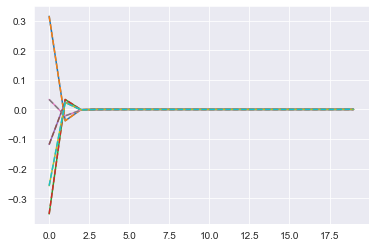

In [8]:
cost_shoot, states_shoot = rollout(env, policy_shooting)
cost_col, states_col = rollout(env, policy_collocation)
states_shoot, states_col = np.array(states_shoot), np.array(states_col)
error = np.linalg.norm(states_col - np.array(states_collocation))
ts = np.arange(states_shoot.shape[0])
print("---- Quantitative Metrics ---")
print("Shooting Cost %.3f" % cost_shoot)
print("Collocation Cost %.3f" % cost_col)
print("Collocation Error %.3f" % error)

print("\n\n---- Qualitative Metrics ---")
print("Evolution of the value of each dimension across 20 timesteps for the shooting methods.")
print("Both methods converge to the origin. Shooting: solid line(-);  Collocation: dashed line(--).")

for i in range(env.dx):
    plt.plot(ts, states_shoot[:, i], '-', ts, states_col[:, i], '--')



# Part 2 [20 pt] - Stability
 A discrete-time linear system is asymptotically stable if in the presence of no input the system converges towards the zero state. In practice, this means that the absolute value of the eigenvalues of the transition matrix must be smaller than 1. If that is not the case, the system is unstable.

For instance, the previous system is stable:

In [9]:
np.abs(np.linalg.eigvals(env.A))

array([0.26052413, 0.14606684, 0.14606684, 0.09743496, 0.09743496])

## [20 pt] Theoretical Question
Consider the linear system that we currently have, i.e., $$x_{t+1} = Ax_t + B u_t$$
and we want to minimize the quadratic cost $$ \frac{1}{2}\sum_t x_t Q x_t$$
Hence, we have a linear quadratic regulator problem. Derive the gradient update for the action variables for both optimization 
methods: shooting and collocation. In the case of collocation, do not include the update due to the constraints.

Explain in a few lines why the shooting method might become unstable while the collocation method does not.

Refer to the pdf for reporting this question.

## [0 pt] Empirical Behaviour

Now, we test the effect that you derived and see if the theory matches the empirical behavior. We use the same environment as in the previous part, but we just scale the transiton matrix so it has some eigenvalues larger than 1. Note this is the only change with respect to the previous part.

In [9]:
env = LinearEnv(multiplier=10.)
np.abs(np.linalg.eigvals(env.A))

array([2.60524128, 1.46066843, 1.46066843, 0.97434961, 0.97434961])

### Shooting

In [10]:
policy_shooting = minimize_shooting(env)

Desired error not necessarily achieved due to precision loss.
The optimal cost is 72284018840248.438


### Collocation

In [11]:
policy_collocation, states_collocation = minimize_collocation(env)

Optimization terminated successfully.
The optimal cost is 201.812


### Evaluation

---- Quantitative Metrics ---
Shooting Cost 72284018840248.438
Collocation Cost 201.812
Collocation Error 0.000


---- Qualitative Metrics ---
Evolution of the value of each dimension across 20 timesteps for the shooting methods.
The shooting method diverges, while the collocation method achieves the desired state. Shooting: solid line(-);  Collocation: dashed line(--).


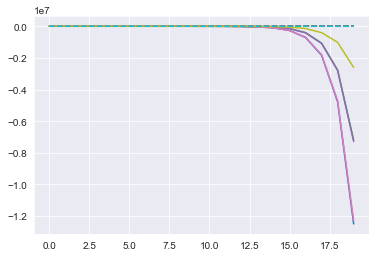

In [12]:
cost_shoot, states_shoot = rollout(env, policy_shooting)
cost_col, states_col = rollout(env, policy_collocation)
states_shoot, states_col = np.array(states_shoot), np.array(states_col)
error = np.linalg.norm(states_col - np.array(states_collocation))
print("---- Quantitative Metrics ---")
print("Shooting Cost %.3f" % cost_shoot)
print("Collocation Cost %.3f" % cost_col)
print("Collocation Error %.3f" % error)

print("\n\n---- Qualitative Metrics ---")
print("Evolution of the value of each dimension across 20 timesteps for the shooting methods.")
print("The shooting method diverges, while the collocation method achieves the desired state. Shooting: solid line(-);  Collocation: dashed line(--).")
ts = np.arange(states_shoot.shape[0])
for i in range(env.dx):
    plt.plot(ts, states_shoot[:, i], '-', ts, states_col[:, i], '--')

# Part 3 [0 pt] - Non-linear Environments
A nice thing of these algorithms is that they can be applied without any modification to non-linear environments such as the MuJoCo ones. For instance, here we learn a sequence of actions that leads to forward movement in the half-cheetah environment.

In [ ]:
env = CheetahModEnv()
init_actions = np.random.uniform(low=-.25, high=.25, size=(env.H * env.du,))
action_shooting = minimize_shooting(env, init_actions)
cost_shooting, states_shooting = rollout(env, action_shooting)

![SegmentLocal](vids/rollout.gif "segment")

# Part 4 [30 pt] - Open-loop vs. Closed-loop
Until now, we have been optimizing directly the sequences of actions and then applying each of the actions in the sequences "blindly". While this suffices in deterministic environments, in the presence of noise it does not work out well usually. Because of the stochastic transitions, the state that you encounter at a specific time-step differs from the one predicted by the optimzation problem; as a result, the action found is no longer valid. In stochastic environments, we need close loop controllers in the form of either (i) parametric policies (e.g. linear feedback controllers or neural-networks), or (ii) non-parametric policies (e.g. model predictive control).

In the following, we will compare the different behaviour of open-loop and closed-loop control methods. Use the optimal cost for the action optimization methods to check the validity of your implementation.

In [14]:
env = CartPoleEnv()

## Action Optimization

In [15]:
action_shooting = minimize_shooting(env)

Optimization terminated successfully.
The optimal cost is 0.008


## [10 pt] Policy Optimization

We will start by learning a neural network policy using a shooting method. Fill in the code for ``eval_policy``.

In [16]:
def eval_policy(env, policy, params):
    """
    Find the cost the policy with parameters params.
    Use the function step of the environment: env.step(action). It returns: next_state, cost, done,
    env_infos.
    
    You can set the parameters of the policy by policy.set_params(params) and get the action for the current state
    with policy.get_action(state).
    """
    state = env.reset()
    total_cost = 0
    horizon = env.H
    
    """YOUR CODE HERE"""

    """YOUR CODE ENDS HERE"""
    return total_cost

In [17]:
def minimize_policy_shooting(env):
    policy_shooting = NNPolicy(env.dx, env.du, hidden_sizes=(10, 10))
    policy_shooting.init_params()
    params = policy_shooting.get_params()

    res = minimize(lambda x: eval_policy(env, policy_shooting, x),
                   params,
                   method='BFGS',
                   options={'xtol': 1e-6, 'disp': False, 'verbose': 2})
    print(res.message)
    print("The optimal cost is %.3f" % res.fun)
    params_shooting = res.x
    policy_shooting.set_params(params_shooting)
    return policy_shooting

policy_shooting = minimize_policy_shooting(env)

Optimization terminated successfully.
The optimal cost is 0.008


## [10 pt] Model Predictive Control

In [18]:
class MPCPolicy(object):
    def __init__(self, env, horizon):
        self.env = env
        self.H = horizon
        self.env = copy.deepcopy(env)
        np.random.seed(1)
        self.init_actions = np.random.uniform(low=-.1, high=.1, size=(horizon * env.du,))
        
    def get_action(self, state, timestep):
        """
        Find the cost of the sequences of actions and state that have shape [horizon, action dimension]
        and [horizon, state_dim], respectively.
        Use the function step of the environment: env.step(action). It returns, next_state, cost, done,
        env_infos.

        In order to set the environment at a specific state use the function self.env.set_state(state)
        """
        env = self.env
        horizon = min(self.H, env.H - timestep)
        
        def eval_mpc(actions, state):
            actions = actions.reshape(horizon, env.du)
            total_cost = 0
            """YOUR CODE HERE"""
           
            """YOUR CODE ENDS HERE"""
            return total_cost

        self.init_actions = np.random.uniform(low=-.1, high=.1, size=(horizon * env.du,))
        res = minimize(lambda x: eval_mpc(x, state),
               self.init_actions, 
               method='BFGS',
               options={'xtol': 1e-6, 'disp': False, 'verbose': 2}
              )
        act_shooting = res.x
        return act_shooting[:env.du]
        

    def reset(self):
        pass

In [19]:
mpc_policy = MPCPolicy(env, env.H)

## Evaluation
### No noise

---- Quantitative Metrics ---
Action Cost 0.008
Policy Cost 0.008
MPC Cost 0.008


---- Qualitative Metrics ---
Evolution of the value of the angle and angular velocity of the cart-pole environment across 50 timesteps for the open-loop, policy controller, and mpc controller.
All the approaches achieve the same cost and follow the same trajectory. Open-loop: solid line(-);  Policy: dashed line(--). MPC: dotted line(.)


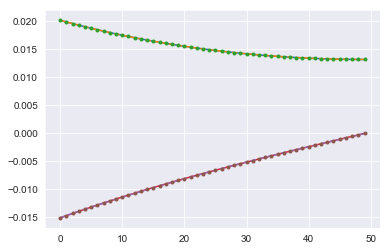

In [20]:
noise = 0.
cost_act, states_act = rollout(env, action_shooting, noise)
cost_pi, states_pi = rollout(env, policy_shooting, noise)
cost_mpc, states_mpc = rollout(env, mpc_policy, noise)
states_act, states_pi, states_mpc = np.array(states_act), np.array(states_pi), np.array(states_mpc)
print("---- Quantitative Metrics ---")
print("Action Cost %.3f" % cost_act)
print("Policy Cost %.3f" % cost_pi)
print("MPC Cost %.3f" % cost_mpc)

print("\n\n---- Qualitative Metrics ---")
print("Evolution of the value of the angle and angular velocity of the cart-pole environment across 50 timesteps for the open-loop, policy controller, and mpc controller.")
print("All the approaches achieve the same cost and follow the same trajectory. Open-loop: solid line(-);  Policy: dashed line(--). MPC: dotted line(.)")
ts = np.arange(states_act.shape[0])
plt.plot(ts, states_act[:, 2], '-', ts, states_pi[:, 2], '--', states_mpc[:, 2], '.')
plt.plot(ts, states_act[:, 3], '-', ts, states_pi[:, 3], '--', states_mpc[:, 3], '.')
plt.show()

### Noise

---- Quantitative Metrics ---
Action Cost 4544.439
Policy Cost 122.799
MPC Cost 55.286


---- Qualitative Metrics ---
Evolution of the value of the angle and angular velocity of the cart-pole environment across 50 timesteps for the open-loop, policy controller, and mpc controller.
In the presence of noise, the open-loop controller fails to stablize the pole, while the policy and mpc controller succeed. The MPC approach achieves the best performance. Open-loop: solid line(-);  Policy: dashed line(--). MPC: dotted line(.)


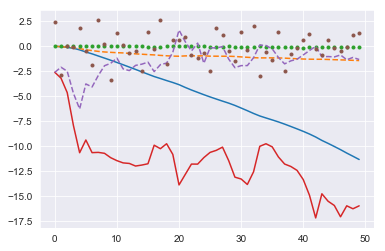

In [21]:
noise = 1.
cost_act, states_act = rollout(env, action_shooting, noise)
cost_pi, states_pi = rollout(env, policy_shooting, noise)
cost_mpc, states_mpc = rollout(env, mpc_policy, noise)
states_act, states_pi, states_mpc = np.array(states_act), np.array(states_pi), np.array(states_mpc)
print("---- Quantitative Metrics ---")
print("Action Cost %.3f" % cost_act)
print("Policy Cost %.3f" % cost_pi)
print("MPC Cost %.3f" % cost_mpc)

print("\n\n---- Qualitative Metrics ---")
print("Evolution of the value of the angle and angular velocity of the cart-pole environment across 50 timesteps for the open-loop, policy controller, and mpc controller.")
print("In the presence of noise, the open-loop controller fails to stablize the pole, while the policy and mpc controller succeed. The MPC approach achieves the best performance. Open-loop: solid line(-);  Policy: dashed line(--). MPC: dotted line(.)")
ts = np.arange(states_act.shape[0])
plt.plot(ts, states_act[:, 2], '-', ts, states_pi[:, 2], '--', states_mpc[:, 2], '.')
plt.plot(ts, states_act[:, 3], '-', ts, states_pi[:, 3], '--', states_mpc[:, 3], '.')
plt.show()

Why does the MPC method perform better than having a policy?
Is there anyway we could make the performance of the policy better?

Reply in no more than 5 lines in the box below.

## [10 pt] Response:

# Part 5 [20 pt] - Optimization Methods
In the previous parts, in order to optimize the collocation methods, we have used a built-in constrained optimization algorithm. However, creating our own contrained optimization solver is fairly easy given a general solver that minimizes unconstrained functions. Here, we implement two solvers by using the merit function.


## [10 pt] Merit function
Given a standard constrained optimization problem:
$$\min_x g_0(x) $$
$$\text{s.t.:} \quad g_i(x) \leq 0 \quad \forall i$$
$$\quad \quad h_j(x) = 0 \quad \forall j$$

We can construct its *merit function* $f_\mu$ as
$$ f_\mu(x) = g_0 +\mu \sum_i |g_i(x)|^+ + \mu \sum_j |h_j(x)| $$

The merit function allows us to transform a constrained optimization problem to an unconstrained one that has the same optimum as $\mu \rightarrow \infty$. Here, we will just solve collocation problems without any constrain on the state space. As a result, we will not have inequality constraints.

In [ ]:
def merit_function(env, mu, x):
    """
    Implementation of the merit function. We use the previously defined functions eval_collocation and constraints
    to obtain the cost and error of the variables.
    
    Note: code it in a way that mu can be either a scalar or a vector
    """
    cost = eval_collocation(env, x)
    cons = constraints(env, x)
    
    """YOUR CODE HERE"""
    merit_val = # Fill this
    """YOUR CODE ENDS HERE"""
    return merit_val

## [5 pt] Penalty Formulation
The easiest implementation is the penalty formulation. The penalty formulation iterates between finding the minimum of the merit function and increasing the scalar value of $\mu$.

In [ ]:
t = 1.5
mu = 1
init_states_and_actions = np.random.uniform(low=-.1, high=.1, size=(env.H * (env.du + env.dx),))
num_iter = 5


for i in range(num_iter):
    """
    Otimization of the penalty function, which after finding the minimium for the merrit function we increase the
    value of mu. The value of mu should be increased as specified in the lecture.
    """  
    
    """YOUR CODE HERE"""
    
    mu = # Fill this
    
    """YOUR CODE ENDS HERE"""
    
    
    res = minimize(lambda x: merit_function(env, mu, x),
               init_states_and_actions,
               method='BFGS', 
               options={'xtol': 1e-6, 'disp': False, 'verbose': 2, 'maxiter':201}
              )
    print("\nIteration %d:"% i)
    print("Value of mu %.3f" % mu)
    print("Inner optimization: %s" % res.message)
    print("Value of merit function %.3f" % res.fun)
    if np.linalg.norm(init_states_and_actions - res.x) < 1e-6: break
    init_states_and_actions = res.x
    
    

states_var_penalty, act_penalty = res.x[:env.H * env.dx], res.x[env.H * env.dx:]
states_var_penalty = states_var_penalty.reshape(env.H, env.dx)
act_penalty = ActPolicy(env, act_penalty) 

## [5 pt] Dual Descent
A better method is the dual descent formulation, which directly solves the Langrangian of the previous optimization problem:
$$ \max_{\lambda_i, \nu_j} \min_x g_0 +\sum_i \lambda_ig_i(x) + \sum_j \nu_j h_j(x) $$

The dual descent method iterates between solving the inner minimization problem and taking a gradient step on the dual variables $\lambda_i$ and $\nu_j$. Here, again, we omit the $g_i$ and $\lambda_i$ terms since we do not have these constraints.

However, using the merit function instead of the Lagrangian results in a more stable behavior. For this excersice, we use the merit function. In such case, the function $h_j(x)$ is $|x_{j+1} - f(x_j, u_j)|$.

In [ ]:
init_states_and_actions = np.random.uniform(low=-.1, high=.1, size=(env.H * (env.du + env.dx),))
nu = 1.5 * np.ones_like(constraints(env, init_states_and_actions))
alpha = 1
num_iter = 5

for i in range(num_iter):
    """
    Otimization using dual descent, at each iteration we find the optimal for the merrit function, and then take
    a gradient step for nu.
    """ 
    res = minimize(lambda x: merit_function(env, nu, x),
               init_states_and_actions,
               method='BFGS', 
               options={'xtol': 1e-6, 'disp': False, 'verbose': 0, 'maxiter':201}
              )
    print("\nIteration %d:"% i)
    print("Norm of nu %.3f" % np.linalg.norm(nu))
    print("Inner optimization: %s" % res.message)
    print("Value of lagrangian %.3f" % res.fun)
    if np.linalg.norm(init_states_and_actions - res.x) < 1e-6: break
        
    init_states_and_actions = res.x

    """
    Use the function constraints(env, init_state_and_actions) and the learning rate alpha to update the
    value of mu.
    """
    """YOUR CODE HERE """
    nu = # Fill this
    """YOUR CODE ENDS HERE"""

states_var_dual_descent, act_dual_descent = res.x[:env.H * env.dx], res.x[env.H * env.dx:]
states_var_dual_descent = states_var_dual_descent.reshape(env.H, env.dx)
act_dual_descent = ActPolicy(env, act_dual_descent) 

# Evaluation

In [ ]:
cost_penalty, states_penalty = rollout(env, act_penalty)
cost_dual_descent, states_dual_descent = rollout(env, act_dual_descent)
states_penalty, states_dual_descent = np.array(states_penalty), np.array(states_dual_descent)
error_penalty = np.linalg.norm(states_penalty - np.array(states_var_penalty))
error_dual_descent = np.linalg.norm(states_dual_descent - np.array(states_var_dual_descent))

print("---- Quantitative Metrics ---")
print("Cost Penalty %.3f" % cost_penalty)
print("Cost Dual Descent %.3f" % cost_dual_descent)

print("Error Penalty %.3f" % error_penalty)
print("Error Dual Descent %.3f" % error_dual_descent)

print("\n\n---- Qualitative Metrics ---")
print("Evolution of the value of the angle and angular velocity of the cart-pole environment across 50 timesteps for the penalty and dual descent methods.")
print("Dual descent yields to slighlthly better results. Both present non-zero error on the constraints and fail to stabilize the cart-pole.  Penalty: solid line(-);  Dual descent: dashed line(--).")
ts = np.arange(states_penalty.shape[0])
plt.plot(ts, states_penalty[:, 2], '-', ts, states_dual_descent[:, 2], '--')
plt.plot(ts, states_penalty[:, 3], '-', ts, states_dual_descent[:, 3], '--')
plt.show()